# Get Disparity Map with a Stereo Camera

## With this code, 
- We get a calibration file like [KITTI dataset](https://www.cvlibs.net/datasets/kitti/).

    - [calibration_file](./output/fisheye_calib_params.txt)

- We get disparity maps for depth-estimation. <br>
  Depth estimation is done in another jupyter notebook with KITTI dataset.

    <img src="./resources/fisheye_calib_res01.png" width="600">

## Preparation
1. Measure the charuco board square size.
2. Caputre 20 ro more charuco board images.

## This code steps
1. Set charuco board parameters
2. Load images
3. Get matching points with world space and image space
4. Corner Matching
5. Calibration
    - Estimate camera parameters(K, D), and camera pose matrix(R_list, t_list).
    - Estimate new camera parameter(K) to undistort images
    - Calculate rectification map

## Device
- I used this fish-eye camera.<br>
<img src="./resources/my_stereo_camera.png" width="600">

In [23]:
from glob import glob
import numpy as np
import sys, os, cv2, inspect
import matplotlib.pyplot as plt
import importlib

## 1. User Settings : Charuco board parameters
- I used a charuco board on our display to calibrate a fish-eye image

     <img src="./board/charuco_15.0_inch_7x4_39.33_mm.png" width="600">

- To detect corners with open-cv, we need to create a charuco board object.

In [ ]:
# Board Settings
real_square_size_m = 39.33/1000.0 # [m] Measure real size.
real_marker_size_m = real_square_size_m * 0.75 # The same setting when I created the charuco image.
square_num_x = 7   # odd number of squares along the x-axis
square_num_y = 4   # even number of squares along the y-axis

# Chessboard configuration
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
     
# Create boadr instance
board = cv2.aruco.CharucoBoard((square_num_x, square_num_y), real_square_size_m, real_marker_size_m, aruco_dict)

# Get corner points in world space
charuco_world_points = board.getChessboardCorners()
charuco_world_points_num = len(charuco_world_points)

# Check the result
print(f'charuco_world_points: size = {charuco_world_points.shape} \n')
print(f'type = {type(charuco_world_points)} \n')
print(f'corner xyz in world space \n {charuco_world_points[:5]}')

## 2. Load captured image files

In [ ]:
# get image file paths
folder_path_charuco_stereo = './calibration/stereo_7x4_39.33mm'
file_paths_charuco_stereo_left = sorted(glob(folder_path_charuco_stereo + '/*left*.png'))
file_paths_charuco_stereo_right = sorted(glob(folder_path_charuco_stereo + '/*right*.png'))      

# check image file 
img = cv2.imread(file_paths_charuco_stereo_left[0], cv2.IMREAD_GRAYSCALE)
img_num = len(file_paths_charuco_stereo_left)
img_shape = img.shape
img_size  = (img_shape[1], img_shape[0]) # (width, height)
print(f'file_path = {file_paths_charuco_stereo_left[0]}')
print(f'image num   = {img_num}')
print(f'image shape = {img.shape}')
print(f'image size = {img_size}')

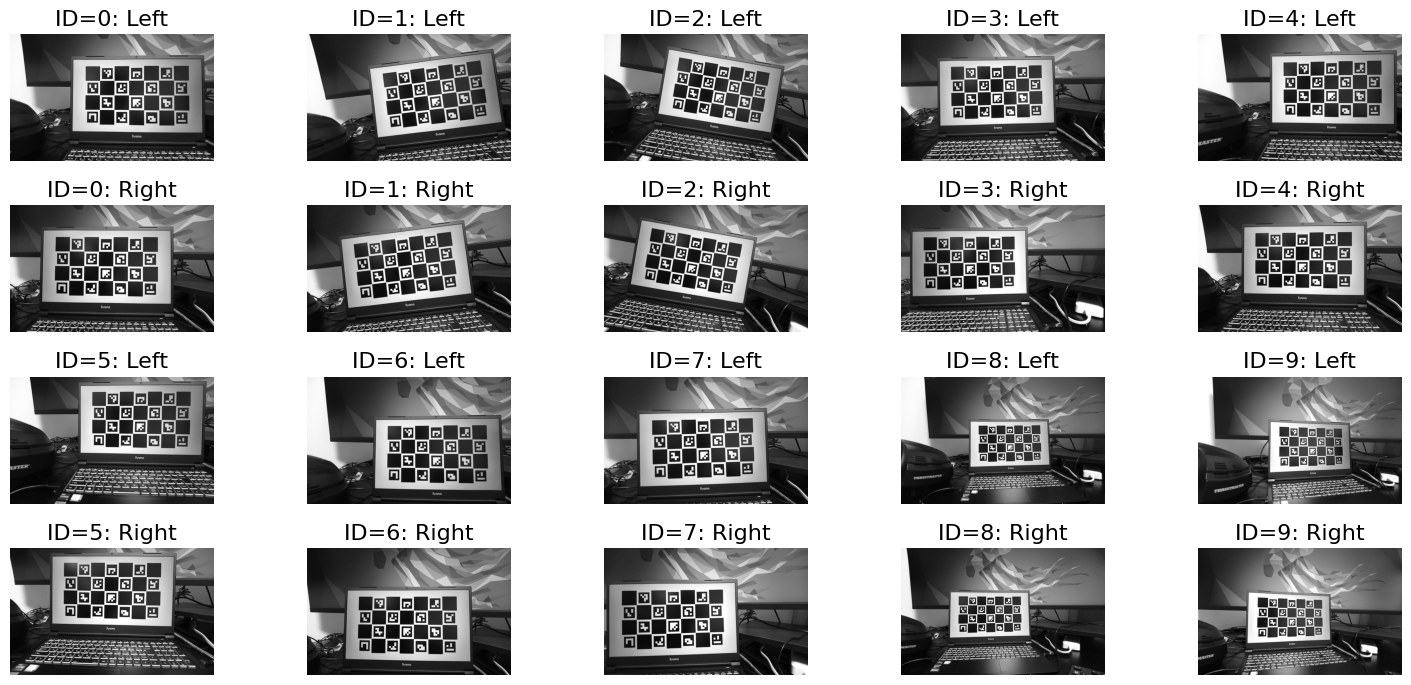

In [4]:
# view images
img_num = 10
cols = 5
rows = (img_num*2) // 5

fig, axs = plt.subplots(rows, cols, figsize=(15,7))
fig.tight_layout()

for i in range(img_num):
    # load image
    img_left = cv2.imread(file_paths_charuco_stereo_left[i], cv2.IMREAD_GRAYSCALE)
    img_right = cv2.imread(file_paths_charuco_stereo_right[i], cv2.IMREAD_GRAYSCALE)
    
    # calc image pos
    row = i // cols
    col = i % cols
    
    # plot left camera image
    axs[row*2, col].imshow(img_left, cmap='gray')
    axs[row*2, col].axis('off')
    axs[row*2, col].set_title(f'ID={i}: Left', fontsize=16)
    
    # plot right camera image
    axs[row*2+1, col].imshow(img_right, cmap='gray')
    axs[row*2+1, col].axis('off')
    axs[row*2+1, col].set_title(f'ID={i}: Right', fontsize=16)    
    

## 3. Stereo Calibration
- Step-1. Detect corners
- Step-2. Match corners
- Step-3. Mono Vision Calibration
- Step-4. Stereo Vision Calibration

In [5]:
# Create Corner Detector
parameters =  cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_CONTOUR
detector = cv2.aruco.CharucoDetector(board, detectorParams=parameters)

In [12]:
# Run Stereo Calibration !
from stereo_camera_utility import stereoCalibrate

calib_res = stereoCalibrate(file_paths_charuco_stereo_left, file_paths_charuco_stereo_right, board, detector, charuco_world_points, 
                            detect_thresh=1.00, use_id_matching=True)

Stereo Calibration:  19%|█▉        | 46/239 [00:03<00:16, 11.77it/s]

ID = 44 : detected common_ids num is smaller than 18.0
    len(common_ids) = 15


Stereo Calibration:  23%|██▎       | 54/239 [00:04<00:16, 11.18it/s]

ID = 51 : detected common_ids num is smaller than 18.0
    len(common_ids) = 14


Stereo Calibration:  25%|██▌       | 60/239 [00:04<00:16, 11.18it/s]

ID = 57 : detected common_ids num is smaller than 18.0
    len(common_ids) = 14
ID = 58 : detected common_ids num is smaller than 18.0
    len(common_ids) = 16


Stereo Calibration:  27%|██▋       | 64/239 [00:05<00:16, 10.84it/s]

ID = 61 : detected common_ids num is smaller than 18.0
    len(common_ids) = 16


Stereo Calibration:  28%|██▊       | 68/239 [00:05<00:15, 10.91it/s]

ID = 65 : detected common_ids num is smaller than 18.0
    len(common_ids) = 2
ID = 67 : There are no corners


Stereo Calibration:  33%|███▎      | 78/239 [00:06<00:13, 11.55it/s]

ID = 75 : There are no corners
ID = 76 : There are no corners


Stereo Calibration:  59%|█████▉    | 142/239 [00:11<00:07, 13.25it/s]

ID = 140 : detected common_ids num is smaller than 18.0
    len(common_ids) = 14
ID = 141 : detected common_ids num is smaller than 18.0
    len(common_ids) = 16
ID = 142 : detected common_ids num is smaller than 18.0
    len(common_ids) = 16


Stereo Calibration:  61%|██████    | 146/239 [00:12<00:07, 12.93it/s]

ID = 143 : detected common_ids num is smaller than 18.0
    len(common_ids) = 12
ID = 145 : detected common_ids num is smaller than 18.0
    len(common_ids) = 14


Stereo Calibration:  63%|██████▎   | 150/239 [00:12<00:07, 12.39it/s]

ID = 148 : detected common_ids num is smaller than 18.0
    len(common_ids) = 13
ID = 149 : detected common_ids num is smaller than 18.0
    len(common_ids) = 16
ID = 150 : detected common_ids num is smaller than 18.0
    len(common_ids) = 13


Stereo Calibration:  68%|██████▊   | 162/239 [00:13<00:05, 13.55it/s]

ID = 159 : detected common_ids num is smaller than 18.0
    len(common_ids) = 14
ID = 160 : detected common_ids num is smaller than 18.0
    len(common_ids) = 14
ID = 161 : detected common_ids num is smaller than 18.0
    len(common_ids) = 12


Stereo Calibration:  69%|██████▉   | 166/239 [00:13<00:05, 13.02it/s]

ID = 163 : detected common_ids num is smaller than 18.0
    len(common_ids) = 13
ID = 164 : detected common_ids num is smaller than 18.0
    len(common_ids) = 13


Stereo Calibration:  71%|███████   | 170/239 [00:14<00:05, 12.68it/s]

ID = 168 : detected common_ids num is smaller than 18.0
    len(common_ids) = 14


Stereo Calibration:  79%|███████▉  | 190/239 [00:15<00:03, 12.40it/s]

ID = 188 : detected common_ids num is smaller than 18.0
    len(common_ids) = 16
ID = 190 : detected common_ids num is smaller than 18.0
    len(common_ids) = 16


Stereo Calibration:  82%|████████▏ | 196/239 [00:16<00:03, 12.80it/s]

ID = 194 : detected common_ids num is smaller than 18.0
    len(common_ids) = 15
ID = 195 : detected common_ids num is smaller than 18.0
    len(common_ids) = 14


Stereo Calibration:  89%|████████▊ | 212/239 [00:17<00:02, 13.21it/s]

ID = 210 : detected common_ids num is smaller than 18.0
    len(common_ids) = 15


Stereo Calibration:  94%|█████████▎| 224/239 [00:18<00:01, 12.89it/s]

ID = 222 : detected common_ids num is smaller than 18.0
    len(common_ids) = 16
ID = 223 : detected common_ids num is smaller than 18.0
    len(common_ids) = 15
ID = 224 : detected common_ids num is smaller than 18.0
    len(common_ids) = 15


Stereo Calibration:  95%|█████████▌| 228/239 [00:18<00:00, 12.69it/s]

ID = 225 : detected common_ids num is smaller than 18.0
    len(common_ids) = 15


Stereo Calibration:  98%|█████████▊| 234/239 [00:19<00:00, 13.62it/s]

ID = 230 : detected common_ids num is smaller than 18.0
    len(common_ids) = 15


Stereo Calibration: 100%|██████████| 239/239 [00:19<00:00, 12.28it/s]


Done (2/4) : Corner detection and matching
Done (3/4): Mono vision calibration
Done (4/4): Stereo vision calibration
Used image num for stereo calibration = 206 / 239
Used image ratio for stereo calibration =  86.2 %


In [13]:
print(f'Repfoduction Error, Mono Left  = {calib_res["ret_mono_left"]: .4f}')
print(f'Repfoduction Error, Mono Right = {calib_res["ret_mono_right"]: .4f}')
print(f'Repfoduction Error, Stereo     = {calib_res["ret_stereo"]: .4f}')

Repfoduction Error, Mono Left  =  0.1887
Repfoduction Error, Mono Right =  0.1512
Repfoduction Error, Stereo     =  0.2008


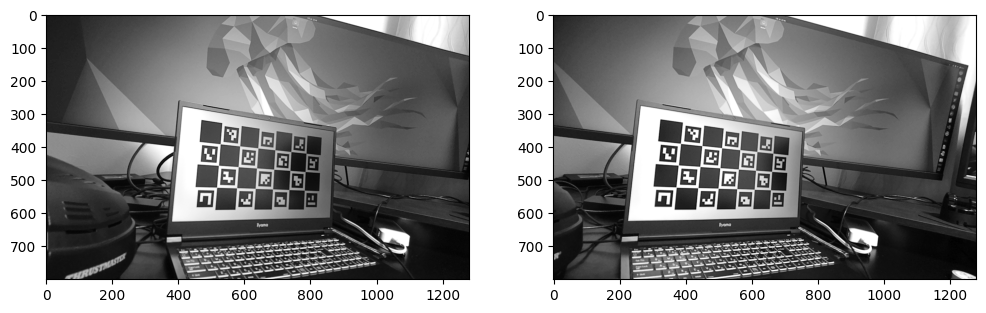

In [14]:
file_id = 10
img_left = cv2.imread(file_paths_charuco_stereo_left[file_id],cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread(file_paths_charuco_stereo_right[file_id],cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_left, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_right, cmap='gray')

### Check Epipolar line

In [15]:
import stereo_camera_utility
importlib.reload(stereo_camera_utility)
from stereo_camera_utility import getStereoRectifiedImage, drawEpipolarLines
from stereo_camera_utility import calcDisparity

In [16]:
# get image file paths
folder_path_others_stereo= './test/stereo_for_disparity'
file_paths_others_stereo_left = sorted(glob(folder_path_others_stereo + '/*left*.png'))
file_paths_others_stereo_right = sorted(glob(folder_path_others_stereo + '/*right*.png'))    

print(f'image_num = {len(file_paths_others_stereo_left)}')  

image_num = 4


line: ax+by+c = 0 // average of -a/b = 0.00841


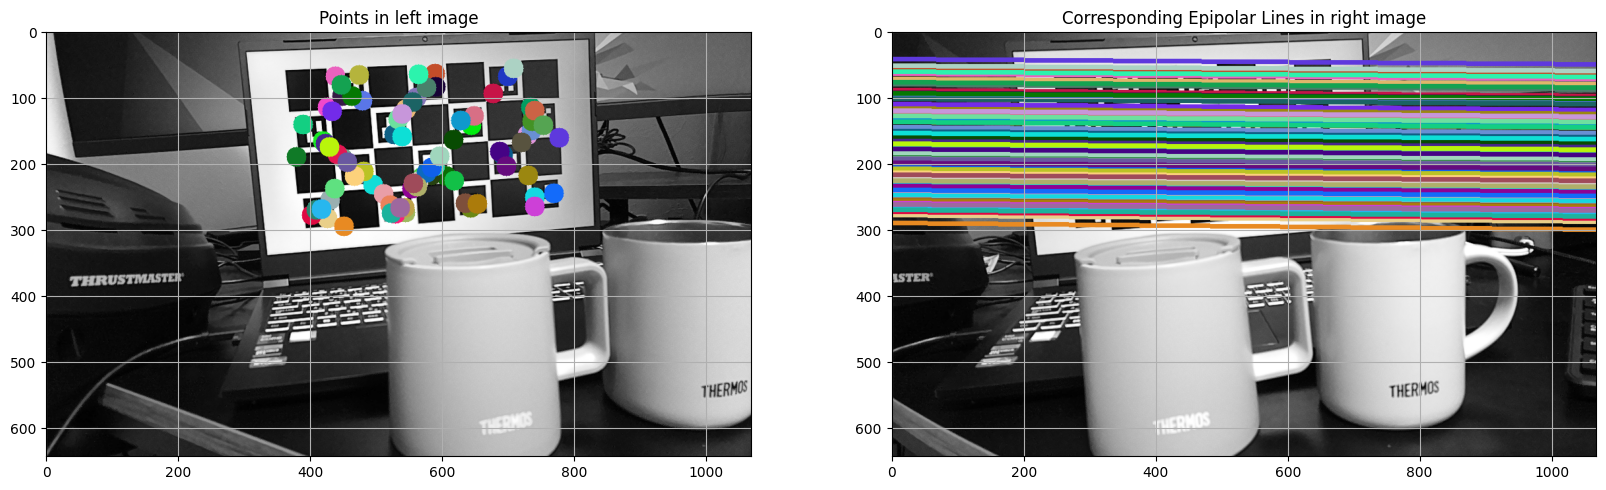

In [17]:
file_id = 0
rectified_img_left, rectified_img_right, rectify_res = getStereoRectifiedImage(file_paths_others_stereo_left[file_id], 
                                                                  file_paths_others_stereo_right[file_id],
                                                                  calib_res['img_size'], 
                                                                  calib_res['K_mono_left'], calib_res['D_mono_left'],
                                                                  calib_res['K_mono_right'], calib_res['D_mono_right'],
                                                                  calib_res['R_stereo'], calib_res['T_stereo'])

rectified_img_left_rgb = cv2.cvtColor(rectified_img_left, cv2.COLOR_GRAY2RGB)
rectified_img_right_rgb = cv2.cvtColor(rectified_img_right, cv2.COLOR_GRAY2RGB)
drawEpipolarLines(rectified_img_right_rgb.copy(), rectified_img_left_rgb.copy(), calib_res['F_stereo'])

### Check image size

In [18]:
print(f'original_img_size = {img_size}')
print("-------------------------")
print(f'rectified_img_left.shape = {rectified_img_left.shape[::-1]}')
print(f'rectified_img_right.shape = {rectified_img_right.shape[::-1]}')
h, w, _ = rectified_img_left_rgb.shape
rectified_img_size = (w, h)

original_img_size = (1280, 800)
-------------------------
rectified_img_left.shape = (1068, 643)
rectified_img_right.shape = (1068, 643)


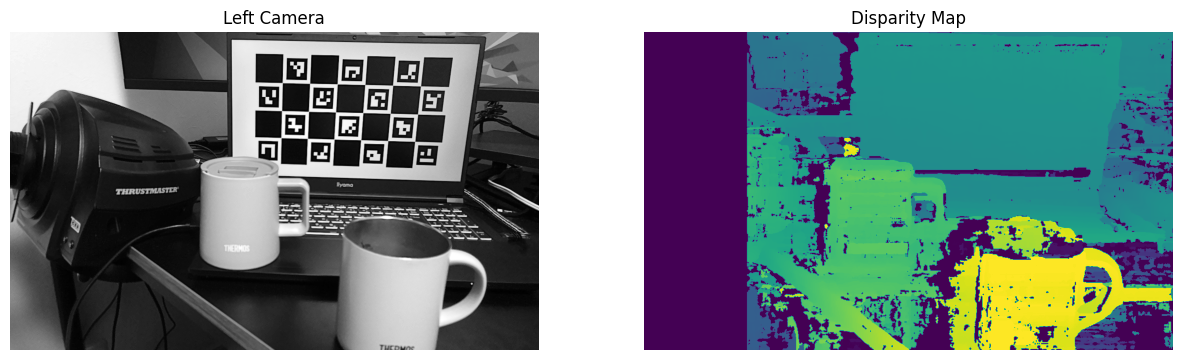

In [26]:
disparity_map = calcDisparity(rectified_img_left, rectified_img_right, matcher="stereo_sgbm")

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.imshow(rectified_img_left, cmap='gray')
plt.title('Left Camera')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(disparity_map)
plt.title('Disparity Map')
plt.axis('off')

plt.savefig('./output/stereo_disparity_map1.png')

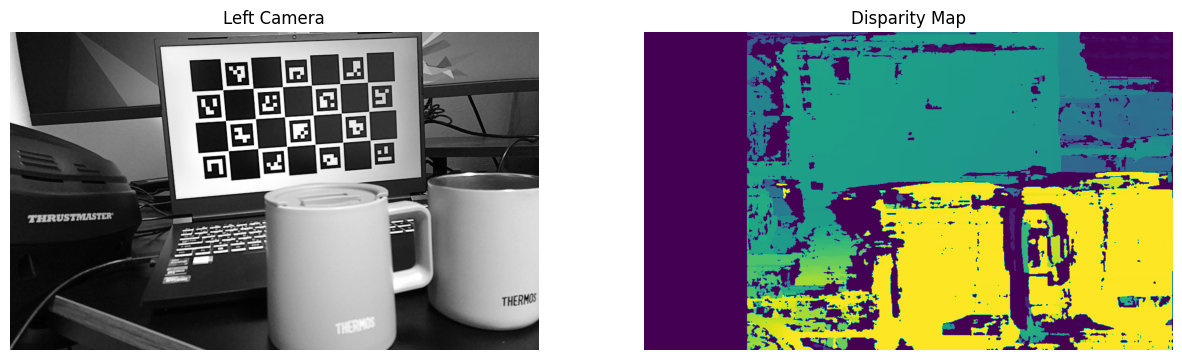

In [ ]:
file_id = 3
rectified_img_left, rectified_img_right, rectify_res = getStereoRectifiedImage(file_paths_others_stereo_left[file_id], 
                                                                  file_paths_others_stereo_right[file_id],
                                                                  calib_res['img_size'], 
                                                                  calib_res['K_mono_left'], calib_res['D_mono_left'],
                                                                  calib_res['K_mono_right'], calib_res['D_mono_right'],
                                                                  calib_res['R_stereo'], calib_res['T_stereo'])

disparity_map = calcDisparity(rectified_img_left, rectified_img_right, matcher="stereo_sgbm")

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(rectified_img_left, cmap='gray')
plt.title('Left Camera')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(disparity_map)
plt.title('Disparity Map')
plt.axis('off')

plt.savefig('./output/stereo_disparity_map2.png')

## 2.6 Create KITTI like calib files


In [21]:
def create_csv_line(params):
    params = params.flatten()
    line = ''
    for i, param in enumerate(params):
        if i == 0:
            line = f'{param: .6e}'
        else:
            line += f', {param: .6e}'
    return line

In [22]:
from datetime import datetime
from pprint import pprint

lines = []

# Info
lines.append(datetime.now().strftime("calib_time: %d-%b-%Y %H:%M:%S"))
lines.append(f"corner_dist: {real_square_size_m: .6e}")

# Left camera
lines.append('S_00 : ' + create_csv_line(np.array(calib_res['img_size'])))
lines.append('K_00 : ' + create_csv_line(calib_res['K_mono_left']))
lines.append('D_00 : ' + create_csv_line(calib_res['D_mono_left']))
lines.append('R_00 : ' + create_csv_line(np.eye(3)))        # Camera 0 の基準 → 単位行列
lines.append('T_00 : ' + create_csv_line(np.zeros((3,1))))  # Camera 0 自身なので 0
lines.append('S_rect_00 : ' + create_csv_line(np.array(rectified_img_size)))
lines.append('R_rect_00 : ' + create_csv_line(rectify_res['R_left']))
lines.append('P_rect_00 : ' + create_csv_line(rectify_res['P_left']))

# Right camera
lines.append('S_01 : ' + create_csv_line(np.array(calib_res['img_size'])))
lines.append('K_01 : ' + create_csv_line(calib_res['K_mono_right']))
lines.append('D_01 : ' + create_csv_line(calib_res['D_mono_right']))
lines.append('R_01 : ' + create_csv_line(calib_res['R_stereo'])) # Camera 0 → Camera 1 の回転
lines.append('T_01 : ' + create_csv_line(calib_res['T_stereo'])) # Camera 0 → Camera 1 の並進
lines.append('S_rect_01 : ' + create_csv_line(np.array(rectified_img_size)))
lines.append('R_rect_01 : ' + create_csv_line(rectify_res['R_right']))
lines.append('P_rect_01 : ' + create_csv_line(rectify_res['P_right']))

# Write to text file
params_file_name = './output/stereo_calib_cam_to_cam.txt'

with open(params_file_name, 'w') as f:
    for line in lines:
        f.write(line + '\n')

pprint(lines)

['calib_time: 17-Aug-2025 00:42:55',
 'corner_dist:  3.933000e-02',
 'S_00 :  1.280000e+03,  8.000000e+02',
 'K_00 :  8.051517e+02,  0.000000e+00,  6.261837e+02,  0.000000e+00,  '
 '8.051748e+02,  3.971181e+02,  0.000000e+00,  0.000000e+00,  1.000000e+00',
 'D_00 :  1.450028e-01, -6.693373e-01, -5.676869e-04,  1.161921e-03,  '
 '7.641058e-01',
 'R_00 :  1.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,  '
 '1.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00',
 'T_00 :  0.000000e+00,  0.000000e+00,  0.000000e+00',
 'S_rect_00 :  1.068000e+03,  6.430000e+02',
 'R_rect_00 :  9.997999e-01,  4.688512e-03, -1.944623e-02, -4.696207e-03,  '
 '9.999889e-01, -3.500338e-04,  1.944437e-02,  4.412873e-04,  9.998108e-01',
 'P_rect_00 :  8.044272e+02,  0.000000e+00,  6.552173e+02,  0.000000e+00,  '
 '0.000000e+00,  8.044272e+02,  3.979996e+02,  0.000000e+00,  0.000000e+00,  '
 '0.000000e+00,  1.000000e+00,  0.000000e+00',
 'S_01 :  1.280000e+03,  8.000000e+02',
 'K_01 :